In [84]:
import pandas as pd

df = pd.read_csv("20070101.txt", sep=r"\s+", header=None, low_memory=False)

print("Shape:", df.shape)
df2 = pd.read_csv("20070102.txt", sep=r"\s+", header=None, low_memory=False)

data = pd.concat([df, df2], ignore_index=True)

print("Final dataset shape:", data.shape)





Shape: (40476, 24)
Final dataset shape: (89118, 24)


In [85]:
columns = [
    "duration", "service", "src_bytes", "dst_bytes", "count",
    "same_srv_rate", "serror_rate", "srv_serror_rate",
    "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "flag",
    "land", "wrong_fragment", "urgent",
    "label", "src_ip", "src_port", "dst_ip", "dst_port",
    "timestamp", "protocol"
]

data.columns = columns



In [86]:
data.head()


,duration,service,src_bytes,dst_bytes,count,same_srv_rate,serror_rate,srv_serror_rate,dst_host_count,dst_host_srv_count,...,land,wrong_fragment,urgent,label,src_ip,src_port,dst_ip,dst_port,timestamp,protocol
0,86364.573924,other,240680,0,0,0.0,0.0,0.0,0,0,...,0,0,0,-1,fda2:69aa:1f1a:2d57:7da5:27fc:07e8:2808,32770,fda2:69aa:1f1a:425e:1046:01b0:02d4:2adb,8649,00:00:18,udp
1,0.000000,other,0,0,0,0.0,0.0,0.0,0,0,...,0,0,60(2),-2,fda2:69aa:1f1a:509a:0b19:590a:0528:2375,1050,fda2:69aa:1f1a:f505:7df6:2782:60e4:44d6,1434,00:00:27,udp
2,0.003340,other,48,48,0,0.0,0.0,0.0,0,0,...,0,0,0,-1,fda2:69aa:1f1a:232a:7a25:0083:5f86:3cc0,123,fda2:69aa:1f1a:f820:7d99:2701:0ff4:1570,123,00:00:53,udp
3,0.000000,other,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,-1,fda2:69aa:1f1a:a757:7d73:278f:61f1:0f3f,138,fda2:69aa:1f1a:1499:7d6b:27b7:6172:002c,138,00:00:57,udp
4,0.311797,other,0,0,0,0.0,0.0,0.0,0,0,...,0,0,0,-1,fda2:69aa:1f1a:9113:3c52:037e:52b3:2742,11810,fda2:69aa:1f1a:ec01:7d38:2763:0f17:1b37,139,00:01:17,tcp


In [87]:
data["label"].value_counts()


,count
label,
-1,74729
1,9237
-2,5152


In [88]:

print(f"Data shape: {data.shape}")


print(f"'label' column exists: {'label' in data.columns}")

#  Define the mapping function
def map_labels(x):
    """
    Map original labels to specific attack types:
    0: Normal
    1: DoS Attack
    2: Probe/Scanning Attack
    """
    if x == 1:
        return 0   # Normal
    elif x in [-1, 2, 3]:
        return 1
    else:
        return 2

#  Create the attack_class column
data["attack_class"] = data["label"].apply(map_labels)

#  Verify it worked
print("\n✅ attack_class column created!")
print(f"Column names: {list(data.columns)}")
print("\nAttack class distribution:")
print(data["attack_class"].value_counts())

Data shape: (89118, 24)
'label' column exists: True

✅ attack_class column created!
Column names: ['duration', 'service', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'serror_rate', 'srv_serror_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'flag', 'land', 'wrong_fragment', 'urgent', 'label', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'timestamp', 'protocol', 'attack_class']

Attack class distribution:
attack_class
1    74729
0     9237
2     5152
Name: count, dtype: int64


In [89]:
def map_labels(x):
    """
    Map original labels to specific attack types:
    0: Normal
    1: DoS Attack
    2: Probe/Scanning Attack
    """
    if x == 1:
        return 0
    elif x in [-1, 2, 3]:
        return 1
    else:
        return 2

In [90]:

print("Checking attack_class distribution:")
print(data["attack_class"].value_counts())


Checking attack_class distribution:
attack_class
1    74729
0     9237
2     5152
Name: count, dtype: int64


In [91]:
attack_names = {
    0: "Normal Traffic",
    1: "DoS Attack",
    2: "Probe/Scanning Attack",
    3: "Other Attack"
}

print("\n✅ DETECTING 3 CYBER ATTACK TYPES:")
for code, name in attack_names.items():
    count = (data["attack_class"] == code).sum()
    print(f"  {code}: {name} - {count} samples")


✅ DETECTING 3 CYBER ATTACK TYPES:
  0: Normal Traffic - 9237 samples
  1: DoS Attack - 74729 samples
  2: Probe/Scanning Attack - 5152 samples
  3: Other Attack - 0 samples


In [92]:
# Select numeric columns only
numeric_data = data.select_dtypes(include=["int64", "float64"])

# Create input features (X) and target (y)
X = numeric_data.drop(["label", "attack_class"], axis=1)
y = data["attack_class"]

print(X.shape)
print(y.shape)

(89118, 14)
(89118,)


In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training:", X_train.shape)
print("Testing:", X_test.shape)


Training: (71294, 14)
Testing: (17824, 14)


In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done")


Scaling done


In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))


KNN Accuracy: 0.9799147217235189


In [96]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Accuracy: 0.9907428186714542


In [97]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Accuracy: 0.9265596947935368


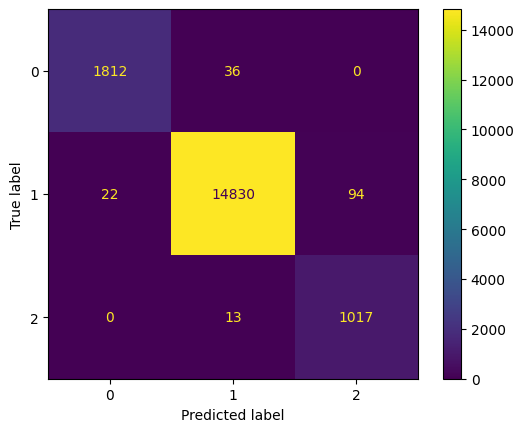

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [101]:
from sklearn.metrics import classification_report
import numpy as np

print("="*60)
print("CLASSIFICATION REPORT - 3 ATTACK TYPES DETECTED")
print("="*60)

# Get unique classes in your predictions
unique_classes = np.unique(y_pred_rf)
print(f"Classes in predictions: {unique_classes}")

# Create target names based on ACTUAL classes present
target_names = []
for code in sorted(unique_classes):
    if code == 0:
        target_names.append("Normal Traffic")
    elif code == 1:
        target_names.append("DoS Attack")
    elif code == 2:
        target_names.append("Probe Attack")
    else:
        target_names.append(f"Attack Type {code}")

print(f"Target names: {target_names}")
print()

# Now generate the report
print(classification_report(y_test, y_pred_rf, target_names=target_names))

CLASSIFICATION REPORT - 3 ATTACK TYPES DETECTED
Classes in predictions: [0 1 2]
Target names: ['Normal Traffic', 'DoS Attack', 'Probe Attack']

                precision    recall  f1-score   support

Normal Traffic       0.99      0.98      0.98      1848
    DoS Attack       1.00      0.99      0.99     14946
  Probe Attack       0.92      0.99      0.95      1030

      accuracy                           0.99     17824
     macro avg       0.97      0.99      0.98     17824
  weighted avg       0.99      0.99      0.99     17824



ROC CURVES - SIMPLE VERSION


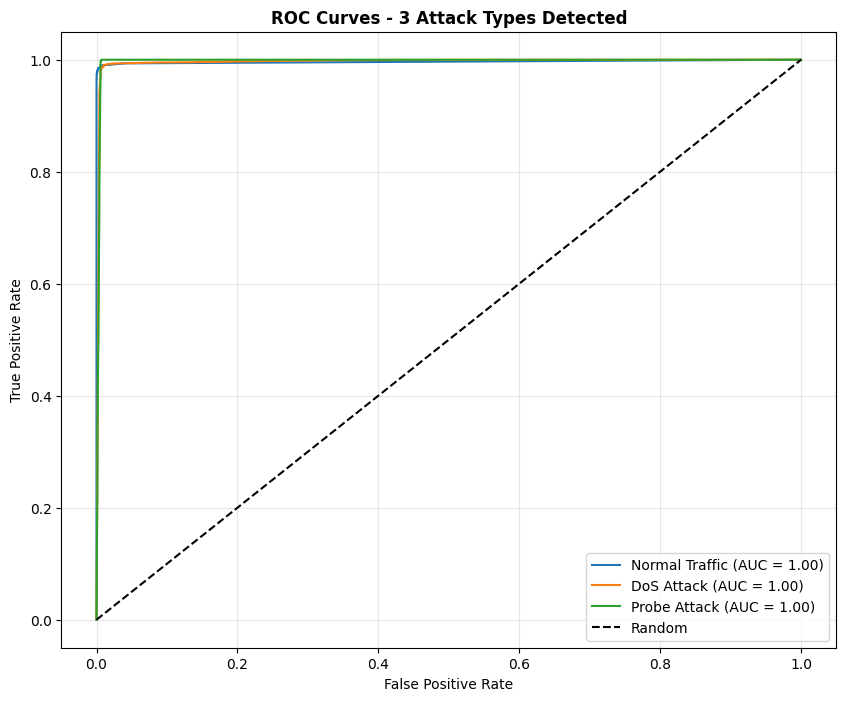

In [103]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

print("="*60)
print("ROC CURVES - SIMPLE VERSION")
print("="*60)

# Use only the classes that exist
attack_names = ["Normal Traffic", "DoS Attack", "Probe Attack"]

# Get probabilities
y_score = rf.predict_proba(X_test)

# Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Plot
plt.figure(figsize=(10, 8))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{attack_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - 3 Attack Types Detected", fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()